## Fetching the data

In [1]:
import os
import tarfile
from six.moves import urllib

# dataset path, and file path to put into
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Retrieve the data from the given url and put it into specified folder."""
    # create the folder in case not exists
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
# fetch_housing_data()

## Visualize and inspect the data

In [136]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [138]:
# insight about the dataset
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [139]:
# inspect the ocean_proximity
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [140]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


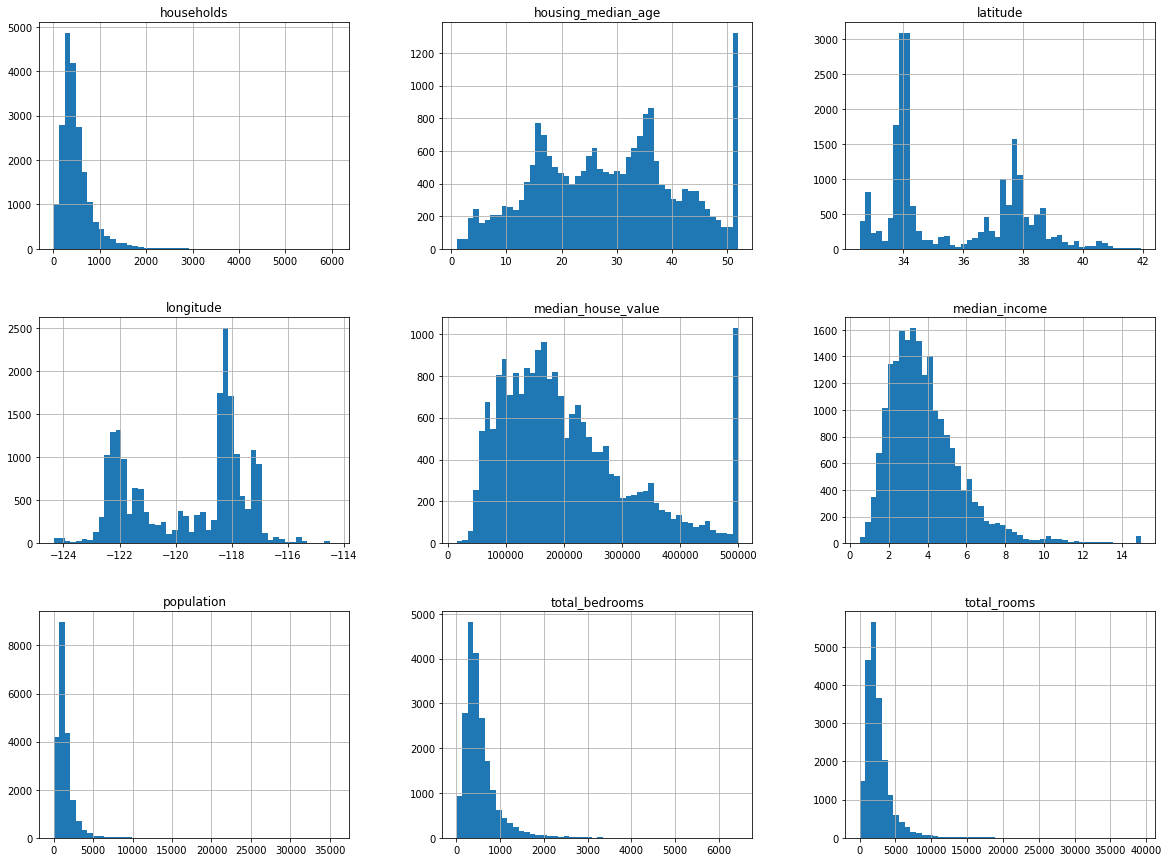

In [141]:
# only in a jupyter notebook
%matplotlib inline

import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

## Splitting the data into train and test sets

#### Manual method

In [142]:
import numpy as np

# set random generator seed
np.random.seed(42)

def split_train_test(data, test_ratio):
    """Split the data into train and test sets."""
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


#### Advanced method

In [143]:
"""If we want to preserve the test set even when new data is added on top of our already existing data,
we should hash the data with unique identifier and then split it w.r.t. this identifier.
"""

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# add an index column
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

# or
# housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id") 

#### Scikit-learn method

In [144]:
"""Another option is to split the data into train and test sets with scikit-learn.
"""

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## Stratified sampling

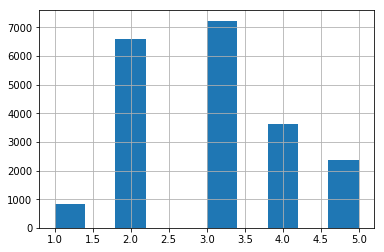

In [145]:
# create income category attribute with 5 categories
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [146]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [147]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [148]:
# let's see if this worked as expectedly
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [149]:
# remove income_cat attribute so that data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop(["income_cat"], axis=1, inplace=True)


## Discover and Visualize the Data

In [150]:
# copy the training set
housing = strat_train_set.copy()

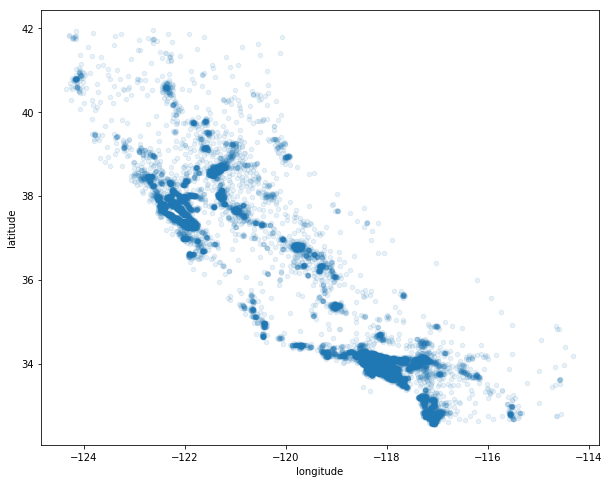

In [151]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10, 8))

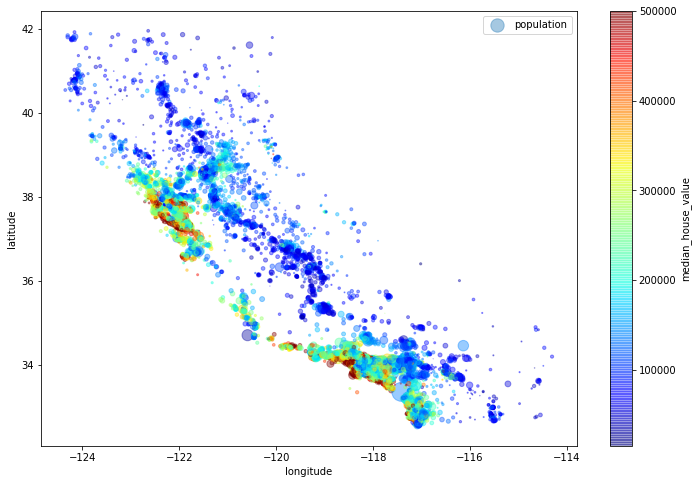

In [152]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             figsize=(12, 8), sharex=False)
plt.legend()

## Correlations

In [153]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7de646278>,
      dtype=object)

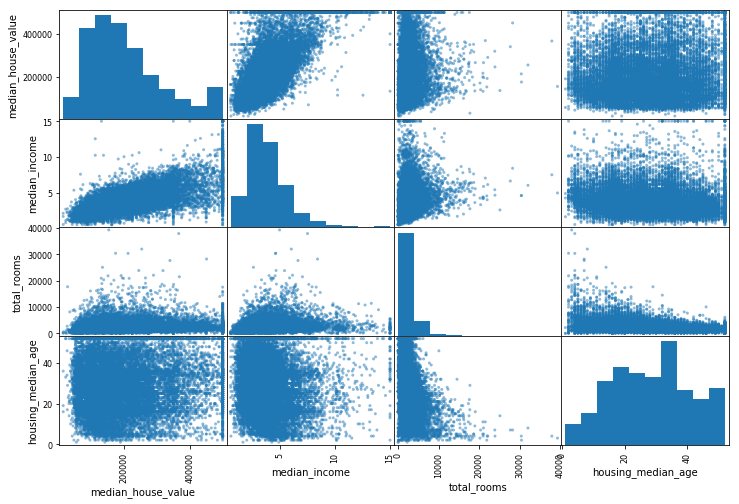

In [154]:
# another way to check for correlations using pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

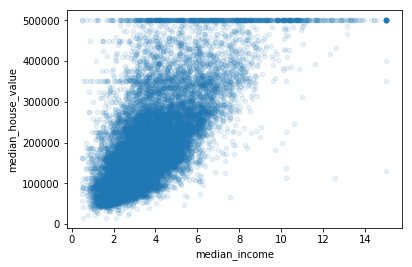

In [155]:
# the most promising one is "median_house_value vs median_income"
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

## Attribute combinations

In [156]:
# lets create new attributes from already existing ones
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

# look at the correlation matrix again
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Starting over

In [157]:
# lets copy the train set once more and start again
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [158]:
"""Three options to handle missing values."""
# housing.dropna(subset=["total_bedrooms"])    # get rid of the corresponding districts
# housing.drop("total_bedrooms", axis=1)       # get rid of the whole attribute
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True) # set the values to some value (mean, median, etc.)

'Three options to handle missing values.'

In [159]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# drop the non numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)

# fit the imputer to the train set
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [160]:
# inspect the medians
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [161]:
X = imputer.transform(housing_num)

In [162]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Categorize the ocean_proximity attribute

In [163]:
from sklearn.preprocessing import OrdinalEncoder

# dataframe of only categorical attribute
housing_cat = housing[["ocean_proximity"]]

oe = OrdinalEncoder()
housing_cat_encoded = oe.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [164]:
oe.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### Directly onehotencoding

In [165]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [166]:
# convert it to numpy array if needed
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [167]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

In [171]:
from sklearn.base import BaseEstimator, TransformerMixin

# column indexes
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [172]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns) + ["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## Transformation Pipelines

In [173]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attr_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [174]:
print(len(housing.values[0]), len(housing_extra_attribs.values[0]), len(housing_num_tr[0]))

9 11 11


## Full Pipeline

In [175]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Training and Evaluation

In [177]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [178]:
# trying the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [179]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [180]:
# DecisionTreeRegressor model -a more complex model-
from sklearn.tree import DecisionTreeRegressor

# train the model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [181]:
# predict on the training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Cross Validation

In [182]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [183]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean: 70666.74616904806
Standard deviation: 2928.322738055112


In [184]:
# perform the same task with linear regressing
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


In [185]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [186]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [187]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


### Save each model to compare when you need

In [188]:
"""
from sklearn.externals import joblib

joblib.dump(my_model, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_modal.pkl")
"""

'\nfrom sklearn.externals import joblib\n\njoblib.dump(my_model, "my_model.pkl")\n# and later...\nmy_model_loaded = joblib.load("my_modal.pkl")\n'

## Fine Tune

### Grid Search

In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [52]:
# result
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [53]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [54]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63753.53157588428 {'max_features': 2, 'n_estimators': 3}
56152.19157870998 {'max_features': 2, 'n_estimators': 10}
52795.228275776964 {'max_features': 2, 'n_estimators': 30}
60450.97370176253 {'max_features': 4, 'n_estimators': 3}
53192.347231742984 {'max_features': 4, 'n_estimators': 10}
50502.27457241198 {'max_features': 4, 'n_estimators': 30}
59451.06851157654 {'max_features': 6, 'n_estimators': 3}
52023.99063518951 {'max_features': 6, 'n_estimators': 10}
49977.5013841624 {'max_features': 6, 'n_estimators': 30}
58376.628149756005 {'max_features': 8, 'n_estimators': 3}
52089.8895065034 {'max_features': 8, 'n_estimators': 10}
50309.2711479205 {'max_features': 8, 'n_estimators': 30}
62494.37431621209 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54586.06607320435 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60092.21371938162 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52607.244176539716 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

### Randomized Search

In [55]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_estimators": range(1, 201),
    "max_features": range(1, 9)
}

forest_reg = RandomForestRegressor()
randomized_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, cv=5,
                                       n_iter=10, random_state=42,
                                       scoring="neg_mean_squared_error")
randomized_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [56]:
# result
randomized_search.best_params_

{'n_estimators': 131, 'max_features': 6}

In [57]:
cvres = randomized_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49162.897784896806 {'n_estimators': 127, 'max_features': 6}
49622.26836521725 {'n_estimators': 60, 'max_features': 8}
49793.18484401599 {'n_estimators': 61, 'max_features': 5}
49158.71621447781 {'n_estimators': 95, 'max_features': 7}
49092.90588704608 {'n_estimators': 131, 'max_features': 6}
49238.31029869434 {'n_estimators': 96, 'max_features': 6}
49589.96343967598 {'n_estimators': 45, 'max_features': 6}
54585.16500023477 {'n_estimators': 122, 'max_features': 1}
50471.64473836393 {'n_estimators': 67, 'max_features': 3}
49558.97114150164 {'n_estimators': 39, 'max_features': 7}


## Analyze the best models and their errors

In [58]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.88085467e-02, 7.33496388e-02, 4.09954065e-02, 1.67091258e-02,
       1.73554988e-02, 1.77318205e-02, 1.59227275e-02, 3.07956727e-01,
       5.38513930e-02, 1.10407460e-01, 9.81576768e-02, 7.59214979e-03,
       1.53346255e-01, 9.45085982e-05, 2.55826347e-03, 5.16280248e-03])

In [89]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.30795672652438416, 'median_income'),
 (0.15334625523523016, 'INLAND'),
 (0.11040745956098118, 'pop_per_hhold'),
 (0.09815767677490277, 'bedrooms_per_room'),
 (0.07880854666610766, 'longitude'),
 (0.07334963881963508, 'latitude'),
 (0.053851393042369335, 'rooms_per_hhold'),
 (0.040995406457984815, 'housing_median_age'),
 (0.017731820497973446, 'population'),
 (0.017355498758235867, 'total_bedrooms'),
 (0.016709125785504313, 'total_rooms'),
 (0.0159227275319888, 'households'),
 (0.007592149789429612, '<1H OCEAN'),
 (0.005162802483529534, 'NEAR OCEAN'),
 (0.0025582634735796506, 'NEAR BAY'),
 (9.450859816373917e-05, 'ISLAND')]

## Evaluate the system on the test set

In [60]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48078.53091897726

In [61]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46075.38723719, 50001.48959379])

# Exercises

### Full pipeline with both preparation and prediction

In [191]:
pipe_with_prediction = Pipeline([
    ("preparation", full_pipeline),
    ("linear", LinearRegression())
])

pipe_with_prediction.fit(housing, housing_labels)
pipe_with_prediction.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

### Trying support vector machine

In [192]:
from sklearn import svm

param_distribs = {
    {
        "kernel": "linear",
        "C": [1, 10, 100, 1000]
    },
    {
        "kernel": "rbf",
        "C": [1, 10, 100, 1000],
        "gamma": [1, 10, 100, 1000]}
}

svm_regressor = svm.SVR()

grid_search_svr = GridSearchCV(svm_regressor, param_distribs, cv=5,
                               scoring="neg_mean_squared_error", return_train_score=True)
grid_search_svr.fit(housing_prepared, housing_labels)

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", Futu

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [193]:
grid_search_svr.best_params_

{'C': 1000, 'kernel': 'linear'}

In [200]:
grid_search_svr.cv_results_["mean_test_score"]

array([-1.26724091e+10, -1.40740792e+10, -7.16631484e+09, -1.34900261e+10,
       -5.12700708e+09, -9.59457960e+09, -4.96255590e+09, -5.03094355e+09])